In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np

In [ ]:
# Set the device
if torch.backends.mps.is_available():
    device = torch.device("mps")  # Apple's Metal Performance Shaders
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using {device} device")

Using cuda device


In [ ]:
# Define the LeNet-5 architecture
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()

        # Convolutional layer 1: 1 input channel (for grayscale images), 6 output channels, 5x5 kernel, 2 padding
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding=2)
        self.sigmoid1 = nn.Sigmoid()
        # Subsampling layer (AvgPooling) with 2x2 kernel and stride 2
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)

        # Convolutional layer 2: 6 input channels, 16 output channels, 5x5 kernel
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.sigmoid2 = nn.Sigmoid()
        # Subsampling layer (AvgPooling) with 2x2 kernel and stride 2
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)

        # Fully connected layer 1: 16*5*5 input features, 120 output features
        self.fc1 = nn.Linear(16*5*5, 120)
        self.sigmoid3 = nn.Sigmoid()
        # Fully connected layer 2: 120 input features, 84 output features
        self.fc2 = nn.Linear(120, 84)
        self.sigmoid4 = nn.Sigmoid()
        # Output layer: 84 input features, 10 output features for 10 classes
        self.fc3 = nn.Linear(84, 10)


    def forward(self, x):
        # Input shape of the image is assumed to be [batch_size, 1, 32, 32]

        # Pass the input through the first convolutional layer, then activation, then pool
        x = self.pool1(self.sigmoid1(self.conv1(x)))
        # Pass the output through the second convolutional layer, then activation, then pool
        x = self.pool2(self.sigmoid2(self.conv2(x)))

        # Flatten the output for the fully connected layer
        x = x.view(x.size(0), -1)  # Flatten the tensor

        # Pass the flattened output through the first fully connected layer, then activation
        x = self.sigmoid3(self.fc1(x))
        # Pass the output through the second fully connected layer, then activation
        x = self.sigmoid4(self.fc2(x))
        # Pass the output through the final output layer
        x = self.fc3(x)

        return x

In [ ]:
# Instantiate the network
lenet5 = LeNet5().to(device)

In [ ]:
# Loss function
criterion = nn.CrossEntropyLoss()

In [ ]:
# Optimizer (SGD is used in the original paper)
optimizer = optim.Adam(lenet5.parameters(), lr=0.001)

In [ ]:
# Dataset loading
transform = transforms.Compose([
    transforms.Resize((28, 28)),  # Resize images to 28x28
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=True)

In [ ]:
# Training loop
for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = lenet5(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,   200] loss: 2.080
[1,   400] loss: 0.895
[1,   600] loss: 0.498
[1,   800] loss: 0.362
[2,   200] loss: 0.266
[2,   400] loss: 0.239
[2,   600] loss: 0.214
[2,   800] loss: 0.195
[3,   200] loss: 0.163
[3,   400] loss: 0.156
[3,   600] loss: 0.143
[3,   800] loss: 0.139
[4,   200] loss: 0.126
[4,   400] loss: 0.115
[4,   600] loss: 0.117
[4,   800] loss: 0.109
[5,   200] loss: 0.097
[5,   400] loss: 0.099
[5,   600] loss: 0.096
[5,   800] loss: 0.088
[6,   200] loss: 0.083
[6,   400] loss: 0.079
[6,   600] loss: 0.077
[6,   800] loss: 0.078
[7,   200] loss: 0.074
[7,   400] loss: 0.065
[7,   600] loss: 0.076
[7,   800] loss: 0.067
[8,   200] loss: 0.062
[8,   400] loss: 0.063
[8,   600] loss: 0.064
[8,   800] loss: 0.060
[9,   200] loss: 0.051
[9,   400] loss: 0.058
[9,   600] loss: 0.061
[9,   800] loss: 0.056
[10,   200] loss: 0.049
[10,   400] loss: 0.046
[10,   600] loss: 0.056
[10,   800] loss: 0.049
Finished Training


In [ ]:
# Testing loop
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = lenet5(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 98 %


In [ ]:
# Function to show images
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [ ]:
# Function to visualize model predictions
def visualize_model_predictions(model, data_loader, num_images=5):
    images, labels = next(iter(data_loader))
    images, labels = images[:num_images].to(device), labels[:num_images].to(device)

    # Get predictions
    with torch.no_grad():
        model.eval()  # Set model to evaluate mode
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    # Plot the results
    imshow(torchvision.utils.make_grid(images.cpu()))
    print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(num_images)))
    print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(num_images)))

In [ ]:
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

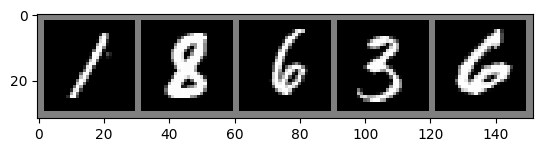

GroundTruth:  1     8     6     3     6    
Predicted:  1     8     6     3     6    


In [ ]:
visualize_model_predictions(lenet5, test_loader)

# Feature visualization

In [ ]:
# Define a function to visualize the feature maps
def visualize_feature_maps(model, input_image, layer_number):
    model.eval()  # Set the model to evaluation mode
    activation = {}

    # Define a function that will copy the output of a layer
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook

    # Attach the hook to the desired layer
    layer_name = f'conv{layer_number}'
    getattr(model, layer_name).register_forward_hook(get_activation(layer_name))

    # Perform a forward pass through the model with the input image
    output = model(input_image)

    # Detach our hooks
    for name, layer in model.named_children():
        if name == layer_name:
            layer._forward_hooks.clear()

    # Plot the feature maps
    act = activation[layer_name].squeeze()
    # Move the activations to CPU and convert to numpy array
    act = act.cpu().numpy()

    # Depending on the number of feature maps, you may need to adjust the subplot dimensions
    num_feature_maps = act.shape[0]
    fig, axarr = plt.subplots(figsize=(15, int(num_feature_maps * 2.5)), nrows=num_feature_maps, ncols=1)
    for idx in range(num_feature_maps):
        ax = axarr if num_feature_maps == 1 else axarr[idx]
        ax.imshow(act[idx], cmap='gray')
        ax.axis('off')
    plt.show()

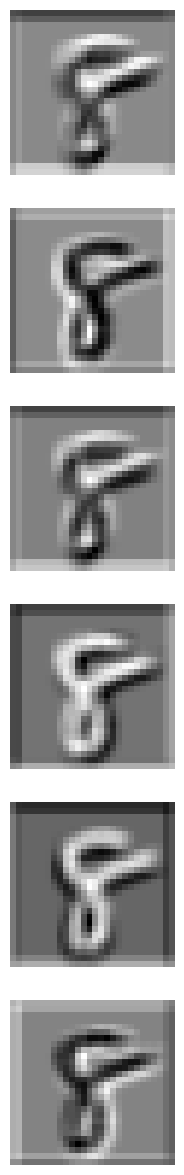

In [ ]:
# Fetch one batch of data from the DataLoader
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Move the batch of images and labels to the GPU
images, labels = images.cuda(), labels.cuda()

# Select the first image from this batch and add an extra batch dimension
# Since MNIST is grayscale, there's only one channel
input_image = images[0].unsqueeze(0).cuda()  # The shape will now be [1, 1, 32, 32]

# Assuming lenet5 is your model and input_image is a single image tensor
# To visualize features from the first convolutional layer
visualize_feature_maps(lenet5, input_image, 1)